**OFFICIAL ZILLOW DEFINITION OF HOME TYPES AND HOUSING STOCK**

- Defines all homes as single-family, condominium and co-operative homes with a county record. Unless specified, all series cover this segment of the housing stock.

- Condo/Co-op: Condominium and co-operative homes.

- Multifamily 2+ units: Units in buildings with 5 or more housing units, that are not a condominiums or co-ops.

- Duplex/Triplex: Housing units in buildings with 2 or 3 housing units.

DS team request single unit properties

predict the values of single unit properties that the tax district assesses using the property data from those whose last transaction was during the "hot months" (in terms of real estate demand) of May and June in 2017.

properties assessed value, 'taxvaluedollarcnt'


In [1]:
use zillow;
# get only hot month
select * from predictions_2017 WHERE transactiondate BETWEEN '2017-05-01' AND '2017-06-30';
# get only single-family home

select count(*) from predictions_2017 pr 
join properties_2017 p on pr.parcelid = p.parcelid 
WHERE pr.transactiondate BETWEEN '2017-05-01' AND '2017-06-30' AND p.unitcnt = 1;

select count(*) from predictions_2017 pr 
join properties_2017 p on pr.parcelid = p.parcelid 
WHERE pr.transactiondate BETWEEN '2017-05-01' AND '2017-06-30' AND p.`propertylandusetypeid` = '261';

# get location
select fips, count(*) from properties_2017 group by fips;
# 06111        Ventura County
# 06059        Orange County
# 06037        Los Angeles County

For the first iteration of your model, use only square feet of the home, number of bedrooms, and number of bathrooms to estimate the properties assessed value, 'taxvaluedollarcnt'. You can expand this to other fields after you have completed an mvp (minimally viable product).

**First attemp**

Use bathroom, bedroom, squarefeet to predict taxable property value in transactions within 5/1/2017 - 6/30/2017

property type id 261, single home

Use Sklearn LinearRegression & OLS, 

(Only split into train/test)

Tax distribution in 3 counties

Re-read instruction & explore other reports
1. Get data in - by category - data dictionary, understand full dataset and #isnull count in each
2. Correlation
3. Feature filter & Lasso & judge from correlation
4. Try polynomial or others
5. Report preparation, conclude take away

In [2]:
import wrangle
property_type = wrangle.get_data_from_mysql()

In [3]:
property_type

,propertylandusetypeid,propertylandusedesc
0,31,Commercial/Office/Residential Mixed Used
1,46,Multi-Story Store
2,47,Store/Office (Mixed Use)
3,246,"Duplex (2 Units, Any Combination)"
4,247,"Triplex (3 Units, Any Combination)"
5,248,"Quadruplex (4 Units, Any Combination)"
6,260,Residential General
7,261,Single Family Residential
8,262,Rural Residence
9,263,Mobile Home


In [1]:
import wrangle
df = wrangle.get_data_from_mysql()
df.describe()

,taxvaluedollarcnt,bathroomcnt,bedroomcnt,roomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet
count,1.501200e+04,15012.000000,15012.000000,15012.000000,15012.000000,1.491200e+04
mean,5.413201e+05,2.326139,3.312883,1.912204,1942.043165,1.054833e+04
std,7.306037e+05,1.021804,0.942607,3.163755,1001.672378,2.938160e+04
min,1.050400e+04,0.000000,0.000000,0.000000,300.000000,5.940000e+02
25%,1.986000e+05,2.000000,3.000000,0.000000,1274.750000,5.595750e+03
50%,3.848850e+05,2.000000,3.000000,0.000000,1679.000000,6.874500e+03
75%,6.449440e+05,3.000000,4.000000,5.000000,2346.000000,8.880000e+03
max,2.385837e+07,11.000000,12.000000,14.000000,15450.000000,1.323788e+06


In [2]:
new_name = ["tax", "bath", "bed", "room_cnt", "sqft", "lot_size"] 
df.rename(columns=dict(zip(df.columns, new_name)), inplace = True)

In [7]:
df.isna().sum()

tax           0
bath          0
bed           0
room_cnt      0
sqft          0
lot_size    100
dtype: int64

In [8]:
# process na
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14912 entries, 0 to 15011
Data columns (total 6 columns):
tax         14912 non-null float64
bath        14912 non-null float64
bed         14912 non-null float64
room_cnt    14912 non-null float64
sqft        14912 non-null float64
lot_size    14912 non-null float64
dtypes: float64(6)
memory usage: 815.5 KB


In [10]:
sns.heatmap(df.corr(),cmap='Blues',annot=True)

In [13]:
df.corr()

,tax,bath,bed,room_cnt,sqft,lot_size
tax,1.000000,0.515989,0.273035,-0.016130,0.602122,0.116279
bath,0.515989,1.000000,0.645013,0.066954,0.853425,0.138025
bed,0.273035,0.645013,1.000000,0.162210,0.628734,0.067230
room_cnt,-0.016130,0.066954,0.162210,1.000000,0.077968,-0.009856
sqft,0.602122,0.853425,0.628734,0.077968,1.000000,0.182638
lot_size,0.116279,0.138025,0.067230,-0.009856,0.182638,1.000000


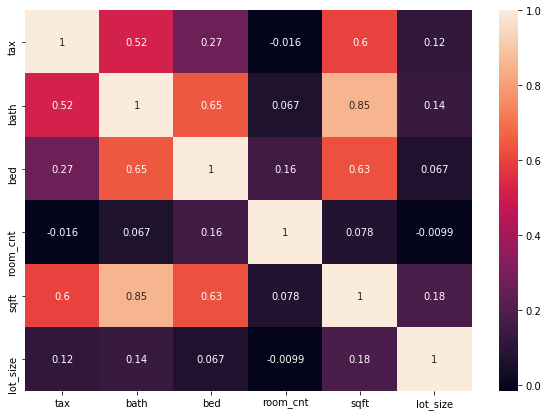